# Iterative linearisation

In this notebook, we approximate the oscillation frequency of a sine function by iterative linearisation of a nonlinear least-squares misfit function.

# 0. Packages and setup

We begin with the import of some Python packages and a few lines to embellish figures.

In [1]:
# Some Python packages.
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import vonmises

# Set some parameters to make plots nicer.
plt.rcParams["font.family"] = "serif"
plt.rcParams.update({"font.size": 40})
plt.rcParams["xtick.major.pad"] = "10"
plt.rcParams["ytick.major.pad"] = "10"

# 1. Misfit curves

The next step is to compute artificial data, in our case a sine curve sampled at regular points in time. To visualise the problem, we plot the misfit as well as its linearisation around some starting model. In the interest of having a clean code, we define the misfit and its linearised version as separate functions.

In [2]:
# Observation times.
t_obs = np.arange(0.0, 4.0 * np.pi, 0.1)
N = len(t_obs)

# Make observations.
d_obs = np.sin(2.0 * t_obs)

In [3]:
# Misfit function.
def chi(m, m0):
    misfit = 0.0
    for i in range(len(t_obs)):
        misfit += 0.5 * (d_obs[i] - np.sin(m * t_obs[i])) ** 2
    return misfit + 0.5 * (m - m0) ** 2

In [4]:
# Linearised version of the misfit function.
def chi_lin(m, mi):
    misfit = 0.0
    for i in range(len(t_obs)):
        misfit += (
            0.5
            * (
                d_obs[i]
                - (np.sin(mi * t_obs[i]) + t_obs[i] * np.cos(mi * t_obs[i]) * (m - mi))
            )
            ** 2
        )
    return misfit + (m - mi)

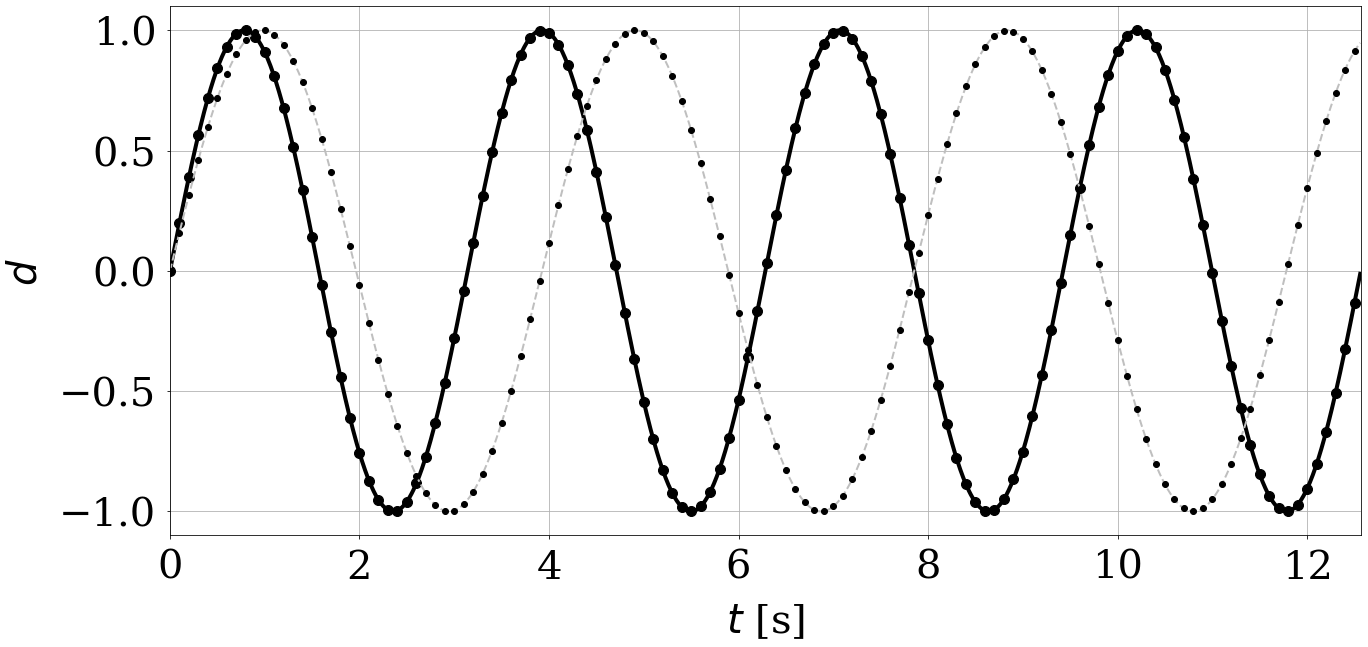

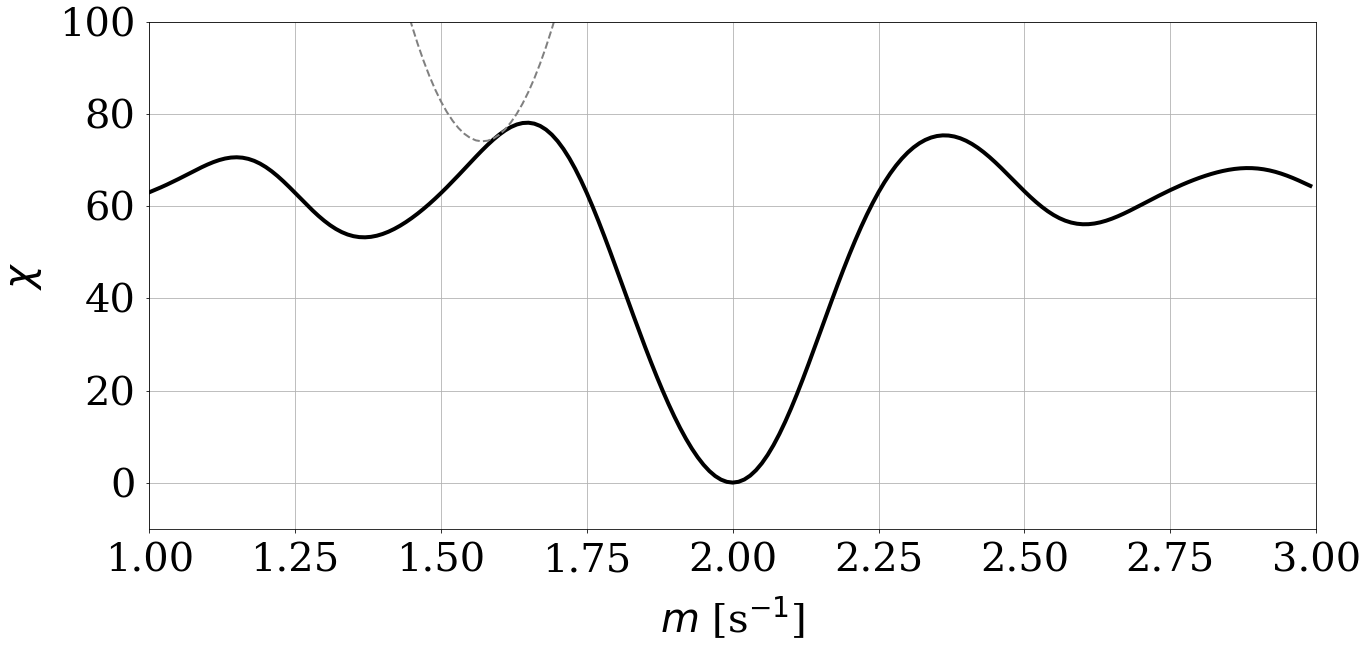

In [12]:
# Range of model parameters for plotting.
m = np.arange(1.0, 3.0, 0.01)
# Initial model around which we linearise first.
#m0 = 1.8 # convergence to global minimum
m0 = 1.6 # converging to local minimum!!


# Plot observed and prior model.
t = np.arange(0.0, 4.0 * np.pi, 0.01)
plt.figure(figsize=(20, 10))
plt.plot(t, np.sin(2.0 * t), "k", linewidth=4)
plt.plot(t_obs, np.sin(2.0 * t_obs), "ko", markersize=10)
plt.plot(t, np.sin(m0 * t), "--", color=[0.75, 0.75, 0.75], linewidth=2)
plt.plot(t_obs, np.sin(m0 * t_obs), "ko")
plt.grid()
plt.xlabel(r"$t$ [s]", labelpad=15)
plt.ylabel("$d$", labelpad=15)
plt.xlim([0.0, 4.0 * np.pi])
plt.tight_layout()
plt.savefig("data.pdf", format="pdf")
plt.show()

# Plot misfit.
plt.figure(figsize=(20, 10))
plt.plot(m, chi(m, m0), "k", linewidth=4)
plt.plot(m, chi_lin(m, m0), "--", color=[0.5, 0.5, 0.5], linewidth=2)
plt.grid()
plt.xlabel(r"$m$ [s$^{-1}$]", labelpad=15)
plt.ylabel(r"$\chi$", labelpad=15)
plt.xlim([1.0, 3.0])
plt.ylim([-10.0, 100.0])
plt.tight_layout()
#plt.savefig("misfit.pdf", format="pdf")
plt.show()

# 2. Iterative linearisation

To perform the iterative linearisation, we first define the forward model $\mathbf{G}$ and its derivative $\mathbf{J}$ as functions. Then we perform a couple of iterations to see how that misfit, the linearised misfit, and the model actually develop.

In [13]:
def G(mi):
    return np.matrix(np.sin(mi[0, 0] * t_obs)).T

In [14]:
def J(mi):
    return np.matrix(t_obs * np.cos(mi[0, 0] * t_obs)).T

[[1.57125338]]
[[1.53525959]]
[[1.49673249]]
[[1.45977052]]
[[1.42764166]]
[[1.40357191]]
[[1.3881521]]
[[1.37915599]]


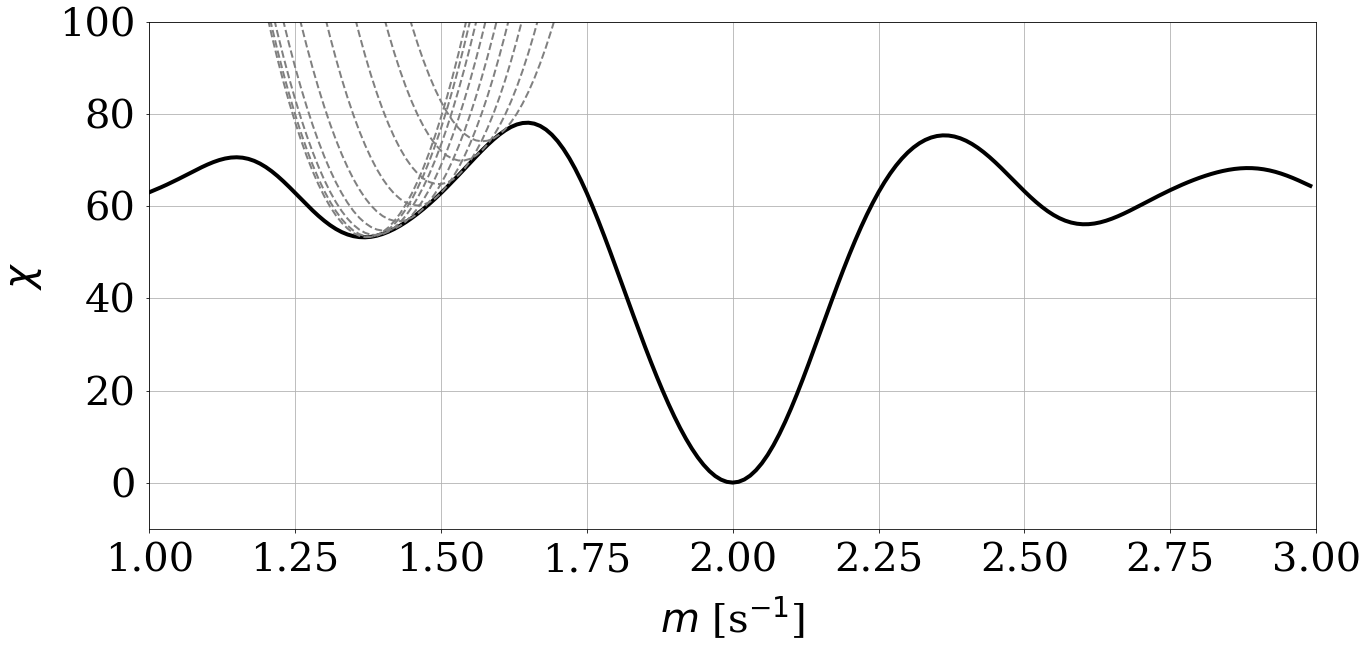

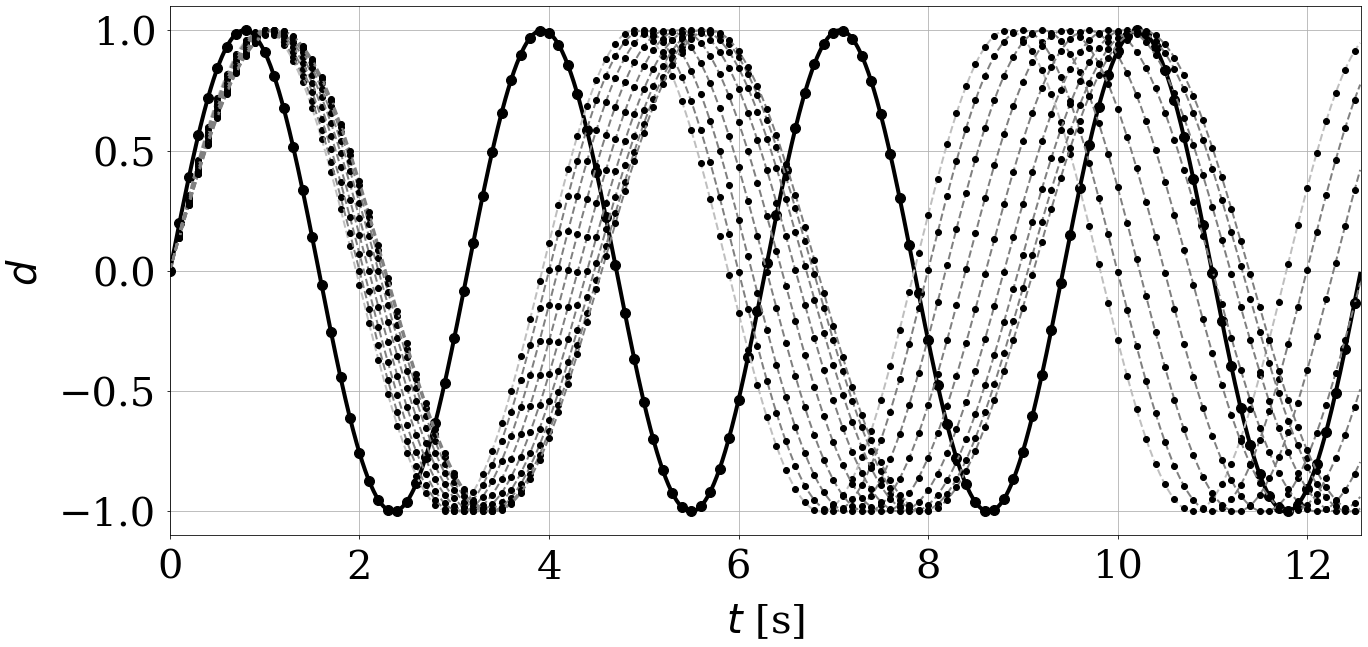

In [15]:
# Plot initial misfit curve.
fig1 = plt.figure(1, figsize=(20, 10))
plt.plot(m, chi(m, m0), "k", linewidth=4)
plt.plot(m, chi_lin(m, m0), "--", color=[0.5, 0.5, 0.5], linewidth=2)
plt.grid()
plt.xlabel(r"$m$ [s$^{-1}$]", labelpad=15)
plt.ylabel(r"$\chi$", labelpad=15)
plt.xlim([1.0, 3.0])
plt.ylim([-10.0, 100.0])

# Plot initial model.
fig2 = plt.figure(2, figsize=(20, 10))
plt.plot(t, np.sin(2.0 * t), "k", linewidth=4)
plt.plot(t_obs, np.sin(2.0 * t_obs), "ko", markersize=10)
plt.plot(t, np.sin(m0 * t), "--", color=[0.75, 0.75, 0.75], linewidth=2)
plt.plot(t_obs, np.sin(m0 * t_obs), "ko")
plt.grid()
plt.xlabel(r"$t$ [s]", labelpad=15)
plt.ylabel("$d$", labelpad=15)
plt.xlim([0.0, 4.0 * np.pi])

# Number of iterations.
nit = 8

# Turn observations and model into a matrix.
d_obs_mat = np.matrix(d_obs).T
mi = np.matrix(m0)

for it in range(nit):

    # Compute data residual.
    delta = d_obs_mat - G(mi)

    # Solve linear system and update.
    invJJT = np.linalg.inv(1.0 * np.identity(N) + np.matmul(J(mi), J(mi).T))
    mi += np.dot(J(mi).T, np.dot(invJJT, delta))
    print(mi)

    # Plot misfit.
    plt.figure(1)
    plt.plot(m, chi_lin(m, mi[0, 0]), "--", color=[0.5, 0.5, 0.5], linewidth=2)

    # Plot model.
    plt.figure(2)
    plt.plot(t, np.sin(mi[0, 0] * t), "--", color=[0.5, 0.5, 0.5], linewidth=2)
    plt.plot(t_obs, np.sin(mi[0, 0] * t_obs), "ko")

plt.figure(1)
plt.tight_layout()
plt.savefig("misfit_evolution.pdf", format="pdf")
plt.figure(2)
plt.tight_layout()
#plt.savefig("data_evolution.pdf", format="pdf")